## Main CF Techniques
2. model based = model "taste" of users and "features" of items
  2.1. matrix factorization – latent factors (e.g. SVD)

### 2.1 Matrix Factorization CF
- main idea: use latent factors of users/items to predict ratings – related to SVD

In [131]:
import numpy as np
import pandas as pd

dense_df = pd.DataFrame(
    {
        'Item1': [5, 3, 4, 3, 1],
        'Item2': [3, 1, 3, 3, 5],
        'Item3': [4, 2, 4, 1, 5],
        'Item4': [4, 3, 3, 5, 2],
    }, index=['Alice', 'User1', 'User2', 'User3', 'User4'])
dense_df

,Item1,Item2,Item3,Item4
Alice,5,3,4,4
User1,3,1,2,3
User2,4,3,4,3
User3,3,3,1,5
User4,1,5,5,2


#### 2.1.1. Singular Value Decomposition
- works only with full matrix, but ratings are sparse matrix
- solutions:
  - value imputation – expensive, imprecise + it kind of defeats the purpose – we want to predict the missing values
  - alternative algorithms (greedy, heuristic):
    - gradient descent
    - alternating least squares

X – matrix of ratings
U – user-factors strengths
V – item-factors strengths
S – importance of factors

In [132]:
x = dense_df.values
u, s, vh = np.linalg.svd(x, full_matrices=False)
u.shape, s.shape, vh.shape

((5, 4), (4,), (4, 4))

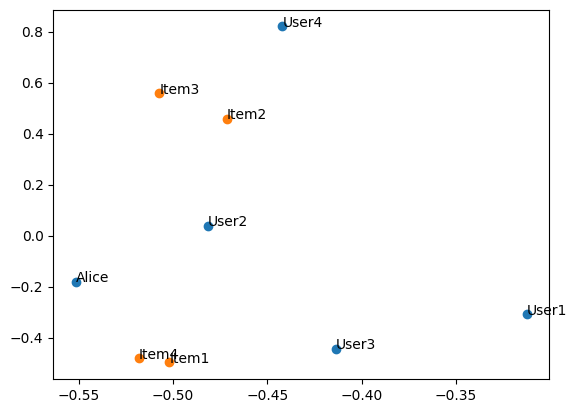

In [133]:
import matplotlib.pyplot as plt

plt.scatter(u[:, 0], u[:, 1])
for i, txt in enumerate(dense_df.index):
    plt.annotate(txt, (u[i, 0], u[i, 1]))

plt.scatter(vh[0, :], vh[1, :])
for i, txt in enumerate(dense_df.columns):
    plt.annotate(txt, (vh[0, i], vh[1, i]))
plt.show()


##### My notes:
- Dimensionality reduction methods, such as SVD, are mostly being used as complementary technique to improve robustness and accuracy of memory-based approach (i.e. the neighborhood algorithms).
- SVD compresses user-item matrix into a low-dimensional representation in terms of latent factors.
    - For example, using 2 latent factors: 

In [134]:
# original
x

array([[5, 3, 4, 4],
       [3, 1, 2, 3],
       [4, 3, 4, 3],
       [3, 3, 1, 5],
       [1, 5, 5, 2]])

In [135]:
n_components = 2
u[:, :n_components] @ np.diag(s[:n_components]) @ vh[:n_components, :]

array([[4.42941411, 3.41492696, 3.6207907 , 4.54626264],
       [2.95960793, 1.51930945, 1.54618642, 3.01070624],
       [3.43046398, 3.38252933, 3.64905693, 3.5470631 ],
       [3.99840948, 1.93732763, 1.95690895, 4.06336525],
       [1.42662221, 4.69291834, 5.28078145, 1.59138396]])

- Another matrix factorization technique is NMF (non-negative matrix factorization):

In [136]:
from sklearn.decomposition import NMF

model = NMF(n_components=n_components, init='random', random_state=0)
w = model.fit_transform(x)
h = model.components_

print(w.shape, h.shape)

w @ h

(5, 2) (2, 4)


array([[4.42917035, 3.4151088 , 3.62080026, 4.54622131],
       [2.95941515, 1.51946877, 1.54613438, 3.01074468],
       [3.43029583, 3.38263828, 3.64912682, 3.54695905],
       [3.99853331, 1.93732728, 1.95655085, 4.06380787],
       [1.42692803, 4.69266007, 5.28088517, 1.59129768]])

### 2.2. Simple Baseline Predictors
1. naive: global mean

In [137]:
sample_df = pd.DataFrame(
    {
        'Item1': [5, 3, 4, 3, 1],
        'Item2': [3, 1, 3, 3, 5],
        'Item3': [4, 2, 4, 1, 5],
        'Item4': [4, 3, 3, 5, 2],
        'Item5': [None, 3, 5, 4, 1],
    }, index=['Alice', 'User1', 'User2', 'User3', 'User4'])
sample_df

,Item1,Item2,Item3,Item4,Item5
Alice,5,3,4,4,NaN
User1,3,1,2,3,3.0
User2,4,3,4,3,5.0
User3,3,3,1,5,4.0
User4,1,5,5,2,1.0


In [138]:
def naive_prediction(df):
    return df.mean().mean()


naive_prediction(sample_df)

3.21

2. naive with biases (average deviations): global mean + user bias + item bias
  - some users/items – systematically larger/lower ratings

In [139]:
def naive_prediction_with_biases(df, user, item):
    global_mean = df.mean().mean()
    user_bias = df.loc[user, :].mean() - global_mean
    item_bias = df.loc[:, item].mean() - global_mean
    return global_mean + user_bias + item_bias


naive_prediction_with_biases(sample_df, 'Alice', 'Item5')

4.04

#### 2.1.2. Gradient Descent
1. assuming centered data without bias
  - user-item interaction via latent factors
  - we need to find qi, pu from the data (finding qi, pu at the same time
  - we want to minimize "squared errors"
     - we want to find q and p that minimize the sum of squared errors
     - in addition, we use regularization to avoid overfitting and therefore minimize the sum of squared errors + `lambda * (norm(qi)^2 + norm(pu)^2)`
     - we can use gradient descent
       - greedy, may not find the global minimum

In [140]:
def collaborative_filtering_gradient_descent(df, epochs, lr, reg):
    # initialize q, p
    np.random.seed(0)
    q = np.random.rand(df.shape[1], 2)
    p = np.random.rand(df.shape[0], 2)
    # iterate over epochs
    for epoch in range(epochs):
        if epoch % 100 == 0:
            total_error = np.nansum(np.square(df.values - np.dot(p, q.T)))
            print(total_error)
        # iterate over users
        for user in range(df.shape[0]):
            # iterate over items
            for item in range(df.shape[1]):
                # if rating exists
                if not np.isnan(df.iloc[user, item]):
                    # compute error
                    error = df.iloc[user, item] - np.dot(q[item, :], p[user, :])
                    # update q, p
                    q[item, :] += lr * (error * p[user, :] - reg * q[item, :])
                    p[user, :] += lr * (error * q[item, :] - reg * p[user, :])
    return q, p


q, p = collaborative_filtering_gradient_descent(sample_df, epochs=1000, lr=0.005, reg=0.02)

206.55411593375243
25.895740851430112
10.482456530686745
8.201815235395841
7.939739056144335
7.906157308468221
7.900985012958545
7.899943885645326
7.899674087942278
7.89959369502714


In [141]:
# compare actual and predicted values
display(sample_df)
predictions = pd.DataFrame(np.dot(p, q.T), index=sample_df.index, columns=sample_df.columns)
predictions

,Item1,Item2,Item3,Item4,Item5
Alice,5,3,4,4,NaN
User1,3,1,2,3,3.0
User2,4,3,4,3,5.0
User3,3,3,1,5,4.0
User4,1,5,5,2,1.0


,Item1,Item2,Item3,Item4,Item5
Alice,4.446579,3.355843,3.599210,4.494487,5.066095
User1,2.825098,1.488435,1.586983,2.789904,3.242849
User2,3.835095,3.319151,3.566057,3.919729,4.353480
User3,3.757385,1.953238,2.082008,3.707886,4.313985
User4,1.183219,4.748873,5.149538,1.589134,1.203420


=> we predict rating 5.07 for Alice for Item5

In [142]:
error_of_naive_prediction = np.nansum(np.square(sample_df.values - naive_prediction(sample_df)))
error_of_naive_prediction

41.9584

In [143]:
error_of_cf = np.nansum(np.square(sample_df.values - predictions.values))
error_of_cf

7.89956932983259

2. with bias
  - prediction = global mean + user bias + item bias + user-item interaction
    - (as opposed to prediction = user-item interaction)
    - _user-item interaction_ is `np.dot(p, q.T)`
  - we minimize the sum of squared errors + `lambda * (norm(qi)^2 + norm(pu)^2) + b_u^2 + b_i^2)`

##### Improvements
- additional data sources (implicit ratings)
- varying confidence level
- temporal dynamics

### 2.3. Slope One
- item-based CF
- like linear regression, but the slope is 1: `f(x) = x + b`
- reduces overfitting, improves performance, easy implementation
- single free paremeter `b`, which is the average difference between two items' ratings

In [144]:
slope_one_df = pd.DataFrame(
    {
        'ItemA': [5, 3, None],
        'ItemB': [3, 4, 2],
        'ItemC': [2, None, 5],
    }, index=['John', 'Mark', 'Lucy'])
slope_one_df

,ItemA,ItemB,ItemC
John,5.0,3,2.0
Mark,3.0,4,NaN
Lucy,NaN,2,5.0


In [145]:
def get_average_diff_df(df):
    avg_diff = pd.DataFrame(0, index=df.columns, columns=df.columns)
    for item1 in df.columns:
        for item2 in df.columns:
            if item1 != item2:
                avg_diff.loc[item1, item2] = (df[item1] - df[item2]).mean()
    return avg_diff


avg_diff_df = get_average_diff_df(slope_one_df)
avg_diff_df

,ItemA,ItemB,ItemC
ItemA,0.0,0.5,3
ItemB,-0.5,0.0,-1
ItemC,-3.0,1.0,0


In [146]:
# predictions are combined using a weighted average where the weight is the number of users having rated both items
def get_weights_df(df):
    weights = pd.DataFrame(0, index=df.columns, columns=df.columns)
    for item1 in df.columns:
        for item2 in df.columns:
            if item1 != item2:
                weights.loc[item1, item2] = sum(df[item1].notnull() & df[item2].notnull())
    return weights


weights_df = get_weights_df(slope_one_df)
weights_df

,ItemA,ItemB,ItemC
ItemA,0,2,1
ItemB,2,0,2
ItemC,1,2,0


In [147]:
def get_prediction_for_user(df, avg_diff, weights, user, item):
    prediction = 0
    for item2 in df.columns:
        if item2 != item:
            users_rating = df.loc[user, item2]
            if not np.isnan(users_rating):
                prediction += (users_rating + avg_diff.loc[item, item2]) * weights.loc[item, item2]
    prediction /= weights.loc[item, :].sum()
    return prediction


get_prediction_for_user(slope_one_df, avg_diff_df, weights_df, 'Lucy', 'ItemA')

4.333333333333333

In [148]:
def get_slope_one_predictions(df):
    avg_diff = get_average_diff_df(df)
    weights = get_weights_df(df)

    predictions_df = pd.DataFrame(0, index=df.index, columns=df.columns)
    for user in df.index:
        for item in df.columns:
            predictions_df.loc[user, item] = get_prediction_for_user(df, avg_diff, weights, user, item)
    return predictions_df


get_slope_one_predictions(slope_one_df)

,ItemA,ItemB,ItemC
John,4.000000,2.75,3.333333
Mark,3.000000,1.25,3.333333
Lucy,4.333333,2.00,2.000000


In [149]:
get_slope_one_predictions(sample_df).loc['Alice']['Item5']

4.25

### 2.4. Clustering
- cluster similar users
- "popularity" for each cluster

#### 2.4.1. K-Means

In [150]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(dense_df)
kmeans.labels_

array([1, 1, 1, 2, 0], dtype=int32)

=> Alice is in the same cluster as User1 and User2, we can use the average rating of these users as the prediction for Alice

In [151]:
sample_df

,Item1,Item2,Item3,Item4,Item5
Alice,5,3,4,4,NaN
User1,3,1,2,3,3.0
User2,4,3,4,3,5.0
User3,3,3,1,5,4.0
User4,1,5,5,2,1.0


In [152]:
def get_cluster_averages(df, n_clusters):
    labels = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(df.dropna(axis=1)).labels_
    
    cluster_averages = pd.DataFrame(0, index=range(n_clusters), columns=df.columns)
    for cluster in range(n_clusters):
        cluster_averages.loc[cluster] = df[labels == cluster].mean()
    return cluster_averages

get_cluster_averages(sample_df, 3)

,Item1,Item2,Item3,Item4,Item5
0,1,5.000000,5.000000,2.000000,1
1,4,2.333333,3.333333,3.333333,4
2,3,3.000000,1.000000,5.000000,4


=> we predict rating 4 for Alice for Item5

#### 2.4.2. Expectation Maximization

In [153]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(dense_df)
gmm.predict(dense_df)

array([1, 1, 1, 2, 0])

### 2.5. Association Rules
- relationships among items, e.g., common purchases ("beer and diapers")
- general machine learning algorithms
- provides explanation, which is useful for building trust
  - "Customers who bought this item also bought..."
- closely related to item-based CF

### 2.6. Classifiers
- general machine learning techniques
- positive / negative classification
- train, test set
- logistic regression, support vector machines, decision trees, Bayesian techniques,...
